## importing libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import os
import numpy as np
import pandas as pd
import keras
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, precision_score, f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder

## loading dataset

In [2]:
base_dir="C:/Users/user/OneDrive/Documents/Body Parts Prediction - Copy/NormalSkin"

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 20
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    shuffle=True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2055 files belonging to 9 classes.


In [5]:
class_names = dataset.class_names
class_names

['Ear',
 'Eye',
 'belly',
 'hands',
 'head',
 'knee',
 'legs',
 'neck and shoulder',
 'nose']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(20, 224, 224, 3)
[2 0 2 3 7 3 6 4 3 5 2 8 6 6 4 6 3 3 3 7]


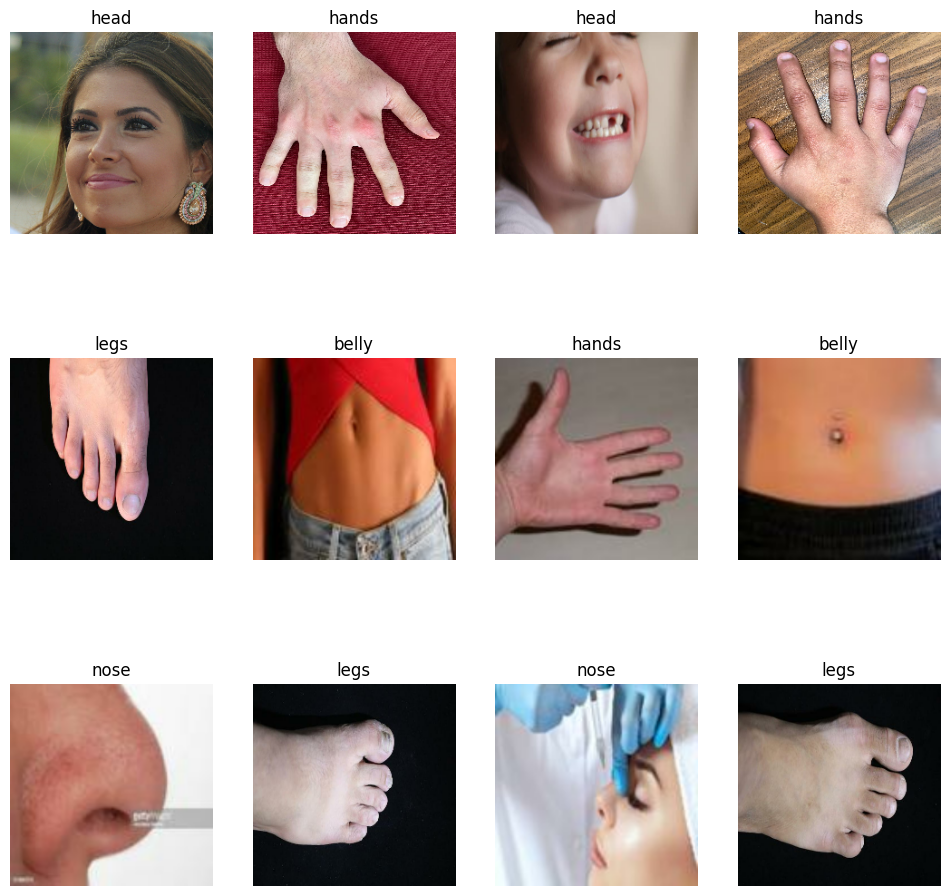

In [7]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## splitting the dataset into train and test

In [8]:
def get_datset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size=10000):
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)
    train_size= int(train_split* ds_size)
    val_size=int(val_split * ds_size)
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds,test_ds = get_datset_partitions_tf(dataset)

In [10]:
len(train_ds), len(val_ds), len(test_ds)

(82, 10, 11)

## data augmentation

In [11]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))),
    tf.keras.layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal" or "vertical"),
   layers.RandomRotation(0.2),
   layers.RandomZoom(0.2),
   #layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
#    layers.RandomContrast(factor=0.1),              # Adjusts contrast randomly by up to 10%
#    layers.RandomBrightness(factor=0.1) 
])

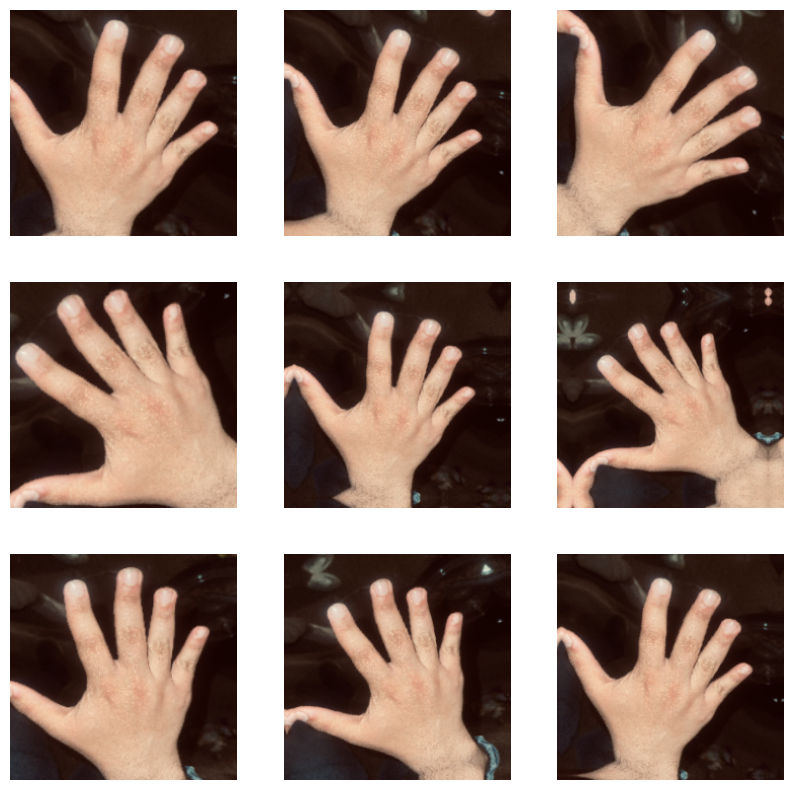

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## modelling

In [14]:
# from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications import EfficientNetB0
# Load pre-trained model 
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

# Add custom layers for fine-tuning
inputs = Input(shape=(224,224, 3))
x=resize_and_rescale(inputs)
x = data_augmentation(inputs)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)  
predictions = Dense(9, activation='softmax')(x)  

# Create the final fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)


In [15]:
#compiling the model
from keras import optimizers
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')
early_stopping = EarlyStopping(
    monitor="val_loss",                          
    patience=5,                                 
    restore_best_weights=True                    
)                              

In [17]:
history = model.fit(
    train_ds,
    epochs=10,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stopping]

)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.6264 - loss: 1.3430 - val_accuracy: 0.9000 - val_loss: 0.3777
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9424 - loss: 0.1600 - val_accuracy: 0.9150 - val_loss: 0.2399
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9677 - loss: 0.1037 - val_accuracy: 0.9200 - val_loss: 0.2768
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9817 - loss: 0.0536 - val_accuracy: 0.9050 - val_loss: 0.3833
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9885 - loss: 0.0302 - val_accuracy: 0.9500 - val_loss: 0.2318
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9918 - loss: 0.0222 - val_accuracy: 0.9550 - val_loss: 0.1853
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9967 - loss: 0.0130 - val_accuracy: 0.9300 - val_loss: 0.2824
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9945 - loss: 0.0152 - val_accuracy: 0.9500 - v

## evaluation

### test data

In [18]:
import numpy as np
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=-1)
    y_pred.extend(predicted_labels)
    y_true.extend(label_batch.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [19]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Print shapes to verify
print("Predicted labels shape:", y_pred.shape)
print("True labels shape:", y_true.shape)

Predicted labels shape: (215,)
True labels shape: (215,)


In [20]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9116279069767442


In [21]:
print(classification_report(y_true, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

              Ear       0.87      1.00      0.93        13
              Eye       1.00      1.00      1.00        13
            belly       0.86      0.89      0.87        27
            hands       0.88      0.98      0.93        45
             head       1.00      1.00      1.00        33
             knee       0.82      0.75      0.78        12
             legs       0.89      0.85      0.87        40
neck and shoulder       0.94      0.80      0.86        20
             nose       1.00      0.83      0.91        12

         accuracy                           0.91       215
        macro avg       0.92      0.90      0.91       215
     weighted avg       0.91      0.91      0.91       215



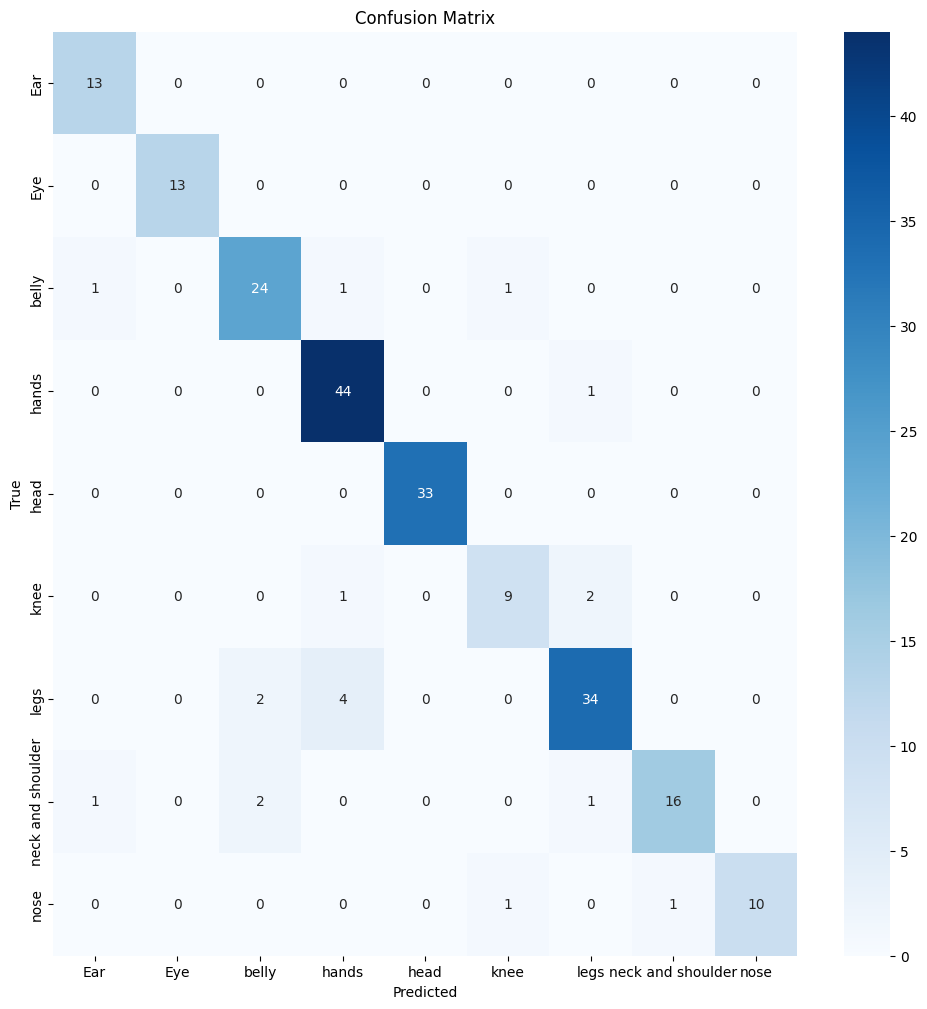

In [22]:
conf_matrix = confusion_matrix(y_true, y_pred)
target_names= class_names
# Plot confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### validation data

In [23]:
import numpy as np
y_pred_val = []
y_true_val = []

for image_batch, label_batch in val_ds:
    predictions1 = model.predict(image_batch)
    predicted_labels1 = np.argmax(predictions1, axis=-1)
    y_pred_val.extend(predicted_labels1)
    y_true_val.extend(label_batch.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [24]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_true_val, y_pred_val)
print("Accuracy:", accuracy)
print(classification_report(y_true_val, y_pred_val, target_names=class_names))

Accuracy: 0.955
                   precision    recall  f1-score   support

              Ear       1.00      0.93      0.96        14
              Eye       1.00      1.00      1.00        12
            belly       0.96      1.00      0.98        23
            hands       0.98      0.96      0.97        48
             head       1.00      1.00      1.00        27
             knee       0.71      1.00      0.83         5
             legs       0.93      0.93      0.93        41
neck and shoulder       0.89      0.84      0.86        19
             nose       1.00      1.00      1.00        11

         accuracy                           0.95       200
        macro avg       0.94      0.96      0.95       200
     weighted avg       0.96      0.95      0.96       200



## Save the model

In [28]:
model.save('bodypart_model.keras')